In [18]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score
from tensorflow.keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Activation, Multiply


In [19]:
# Load the lung images and masks from the dataset

image_dir = r"/mnt/c/Users/prathana/Desktop/k-mam-seg/lung/images"
mask_dir = r"/mnt/c/Users/prathana/Desktop/k-mam-seg/lung/masks"

# Function to load images and masks

def load_data(image_dir, mask_dir, target_size=(128, 128)):
    images = []
    masks = []
    
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name)  # Assuming mask has the same name as image
        
        image = img_to_array(load_img(img_path, color_mode="grayscale", target_size=target_size))
        mask = img_to_array(load_img(mask_path, color_mode="grayscale", target_size=target_size))
        
        images.append(image)
        masks.append(mask)
    
    images = np.array(images)
    masks = np.array(masks)
    
    return images, masks

images, masks = load_data(image_dir, mask_dir)


In [20]:
# Normalize images and masks

images = images / 255.0
masks = masks / 255.0

In [21]:
# Ensure masks are binary

masks = (masks > 0.5).astype(np.float32)

In [22]:
# Train-test split the dataset into training and validation sets

X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [23]:
# Define an Attention U-Net model for lung segmentation

def attention_block(x, g, inter_channel):
    '''
    Attention block for the Attention U-Net.
    Enhances important features by learning attention weights.
    '''
    theta_x = Conv2D(inter_channel, (1, 1), strides=(1, 1), padding='same')(x)
    phi_g = Conv2D(inter_channel, (1, 1), strides=(1, 1), padding='same')(g)
    concat_xg = tf.keras.layers.add([theta_x, phi_g])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), strides=(1, 1), padding='same')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    mul_xg = Multiply()([sigmoid_xg, x])
    return mul_xg

def attention_unet(input_size=(128, 128, 1)):
    '''
    Build an Attention U-Net model.
    Input:
       - input_size: Size of the input image (height, width, channels)
    Output:
       - Model: Compiled Attention U-Net model
    '''
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = tf.keras.layers.Dropout(0.5)(conv5)
    
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    attn6 = attention_block(drop4, up6, 512)
    merge6 = concatenate([attn6, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    attn7 = attention_block(conv3, up7, 256)
    merge7 = concatenate([attn7, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    attn8 = attention_block(conv2, up8, 128)
    merge8 = concatenate([attn8, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    attn9 = attention_block(conv1, up9, 64)
    merge9 = concatenate([attn9, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs, conv10)
    
    return model

model = attention_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 128, 128,  │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_36[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_37[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_38[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_40[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_42[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_43[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 8, 8, 512) │          0 │ dropout_2[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 8, 8,      │  9,438,208 │ conv2d_44[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 8, 8,      │          0 │ conv2d_45[0][0] 

 Total params: 31,730,889 (121.04 MB)

 Trainable params: 31,730,889 (121.04 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Define custom metric functions for evaluating the model performance

def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

def jaccard_index(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + K.epsilon())

model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy', dice_coefficient, precision, recall, f1_score, jaccard_index])


In [25]:
# Train the Attention U-net model

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16)

Epoch 1/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 61s 263ms/step - accuracy: 0.7825 - dice_coefficient: 0.3553 - f1_score: 0.1539 - jaccard_index: 0.2195 - loss: 0.4766 - precision: 0.1947 - recall: 0.1350 - val_accuracy: 0.9240 - val_dice_coefficient: 0.5486 - val_f1_score: 0.8306 - val_jaccard_index: 0.3781 - val_loss: 0.2802 - val_precision: 0.9271 - val_recall: 0.7535
Epoch 2/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 39s 217ms/step - accuracy: 0.9359 - dice_coefficient: 0.5856 - f1_score: 0.8630 - jaccard_index: 0.4148 - loss: 0.2483 - precision: 0.8956 - recall: 0.8383 - val_accuracy: 0.9535 - val_dice_coefficient: 0.6459 - val_f1_score: 0.8991 - val_jaccard_index: 0.4772 - val_loss: 0.2146 - val_precision: 0.9708 - val_recall: 0.8381
Epoch 3/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 40s 219ms/step - accuracy: 0.9645 - dice_coefficient: 0.6690 - f1_score: 0.9270 - jaccard_index: 0.5030 - loss: 0.1881 - precision: 0.9300 - recall: 0.9263 - val_accuracy: 0.9745 - val_dice_coefficient: 0.7022 - val_f1_score: 0.94

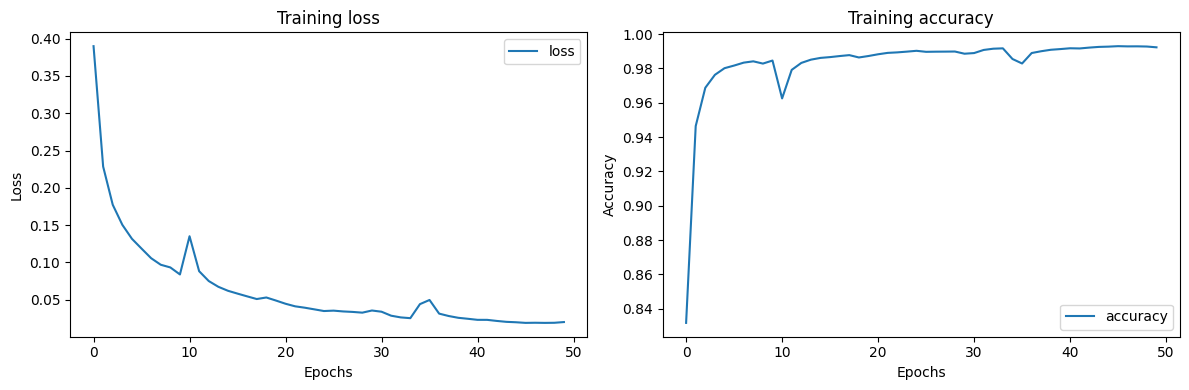

In [34]:
# Function to plot training metrics (loss and accuracy)

def plot_train_metrics(history):
    metrics = ['loss', 'accuracy']
    plt.figure(figsize=(12, 4))

    for i, metric in enumerate(metrics):
        plt.subplot(1, 2, i + 1)
        plt.plot(history.history[metric], label=metric)
        plt.title(f'Training {metric}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_train_metrics(history)

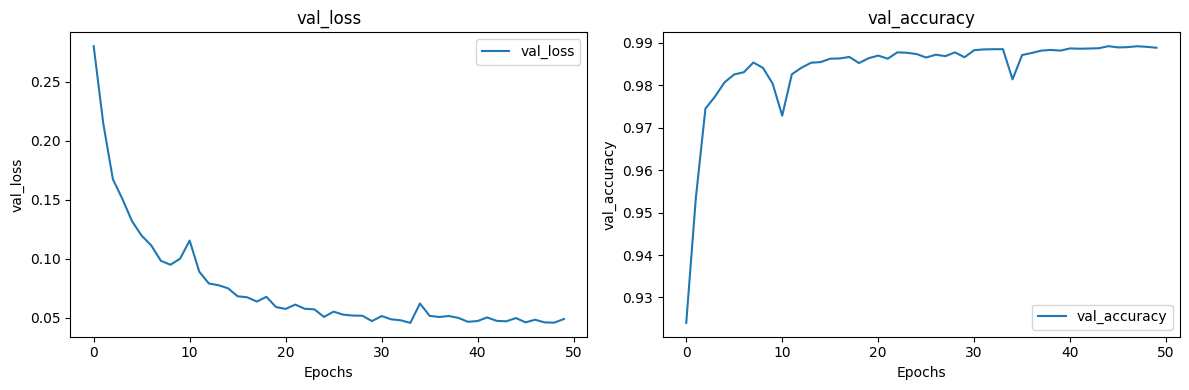

In [26]:
# Plot the validation accuracy and validation loss

def plot_val_metrics(history):
    metrics = ['val_loss', 'val_accuracy']
    plt.figure(figsize=(12, 4))

    for i, metric in enumerate(metrics):
        plt.subplot(1, 2, i + 1)
        plt.plot(history.history[metric], label=metric)
        plt.title(metric)
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_val_metrics(history)


In [27]:
# Predict on validation data

preds = model.predict(X_val)


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step


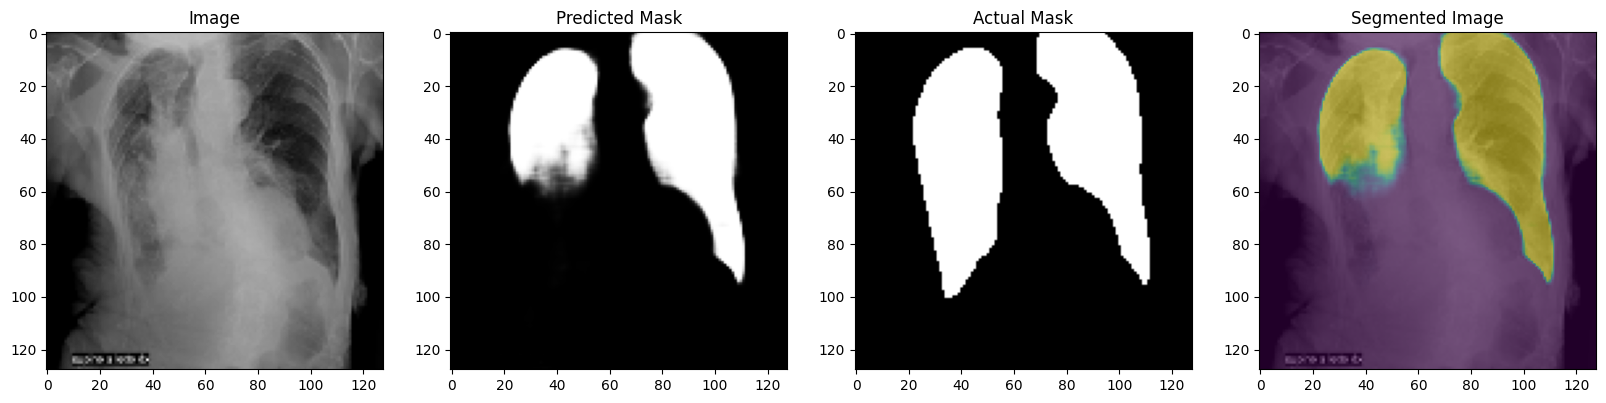

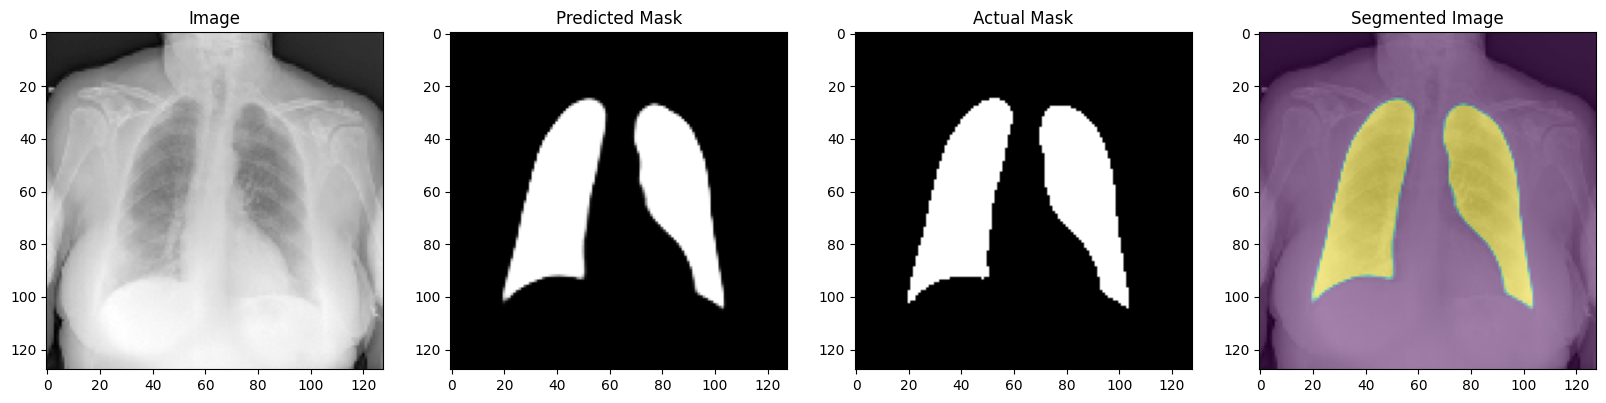

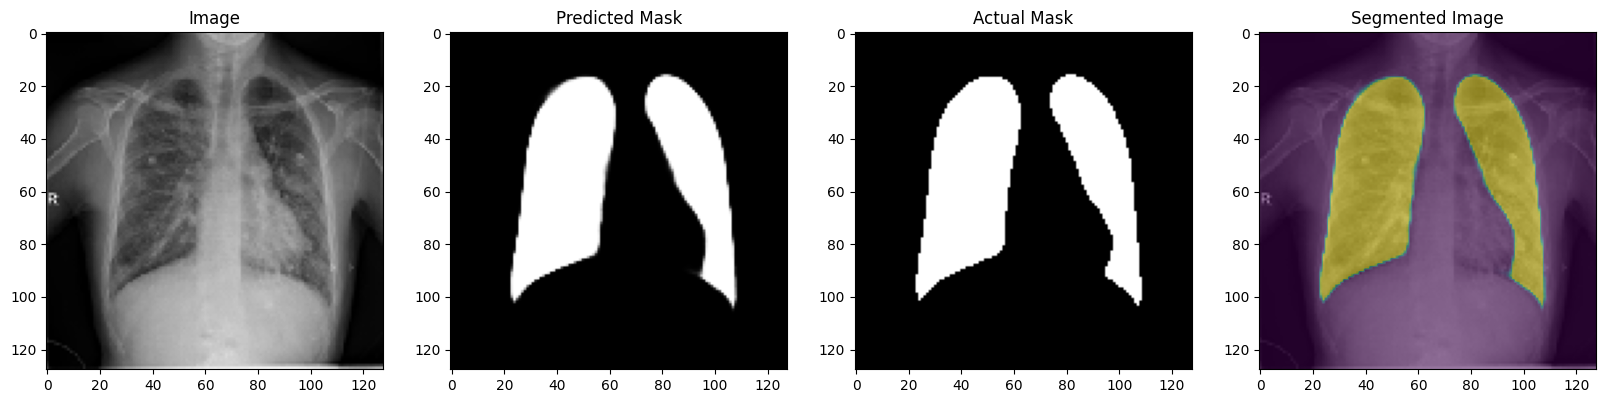

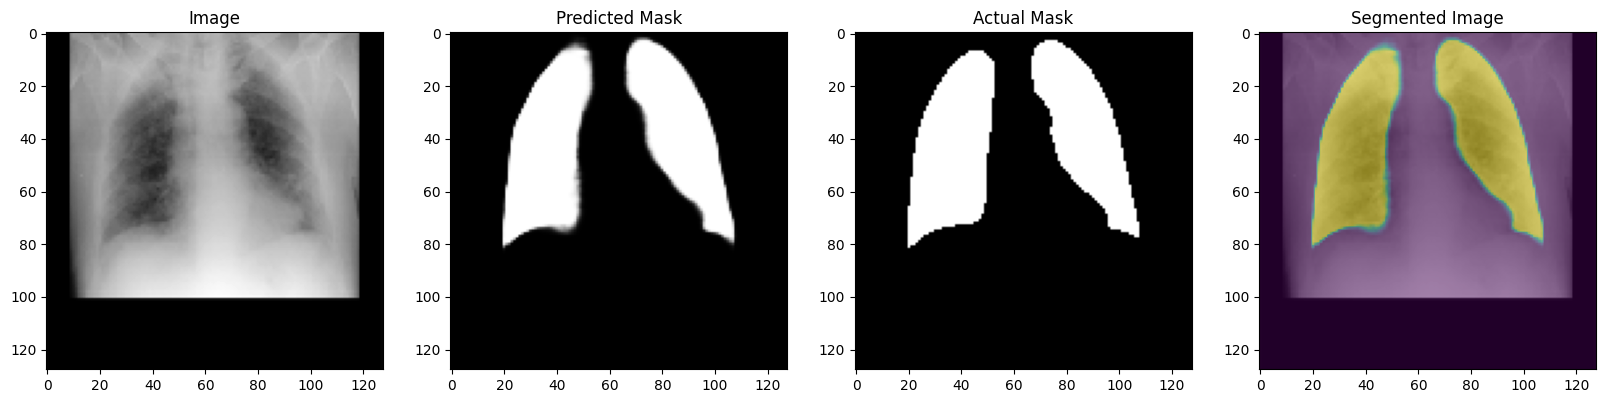

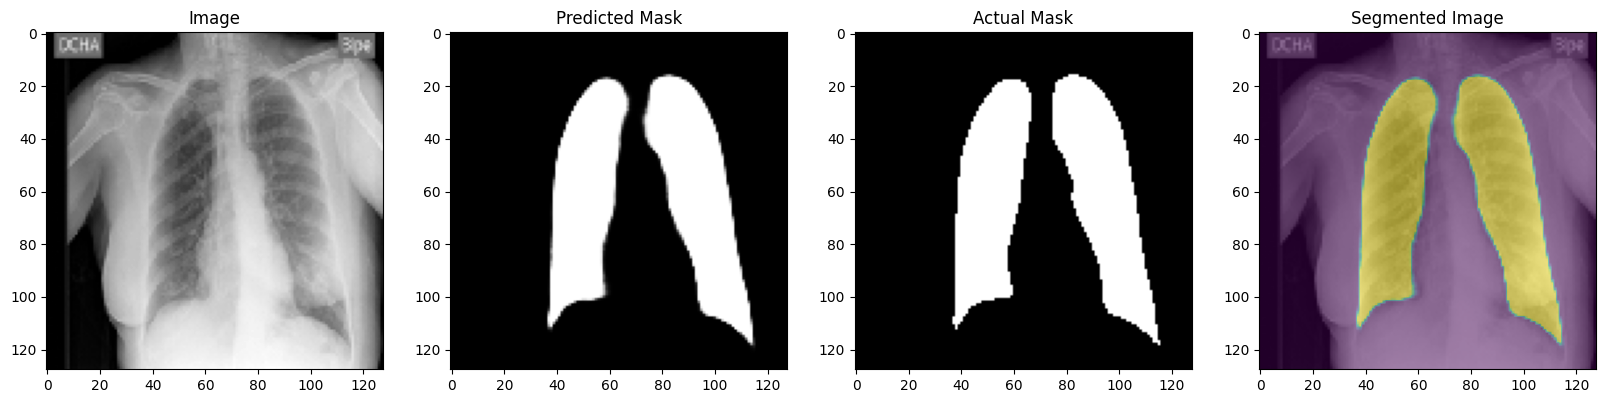

In [28]:
# Visualize the results

def plot_sample(image, mask, pred_mask):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(image.squeeze(), cmap='gray')
    axs[0].set_title('Image')
    axs[1].imshow(pred_mask.squeeze(), cmap='gray')
    axs[1].set_title('Predicted Mask')
    axs[2].imshow(mask.squeeze(), cmap='gray')
    axs[2].set_title('Actual Mask')
    axs[3].imshow(image.squeeze(), cmap='gray')
    axs[3].imshow(pred_mask.squeeze(), alpha=0.5)
    axs[3].set_title('Segmented Image')
    plt.show()

# Display a few samples

for i in range(5):
    plot_sample(X_val[i], y_val[i], preds[i])


In [29]:
# Predict on the validation set

val_preds = model.predict(X_val)
val_preds_binary = (val_preds > 0.5).astype(int)  # Convert probabilities to binary values


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step


In [35]:
# Get the final epoch's validation metrics

val_accuracy = history.history['val_accuracy'][-1]  # Last value of validation accuracy
val_precision = history.history['val_precision'][-1]  # Last value of precision
val_recall = history.history['val_recall'][-1]  # Last value of recall
val_f1_score = history.history['val_f1_score'][-1]  # Last value of f1 score
val_jaccard_index = history.history['val_jaccard_index'][-1]  # Last value of jaccard index
val_dice_coefficient = history.history['val_dice_coefficient'][-1]  # Last value of dice coefficient

# Dice coefficient is often computed using the F1 score for binary classification problems

val_dice_coefficient = 2 * (val_precision * val_recall) / (val_precision + val_recall)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation F1 Score: {val_f1_score:.4f}")
print(f"Validation Jaccard Index: {val_jaccard_index:.4f}")
print(f"Validation Dice Coefficient: {val_dice_coefficient:.4f}")


Validation Accuracy: 0.9889
Validation Precision: 0.9790
Validation Recall: 0.9759
Validation F1 Score: 0.9774
Validation Jaccard Index: 0.9385
Validation Dice Coefficient: 0.9775


In [36]:
# Displaying all the metrics in percentage

val_accuracy_percent = val_accuracy * 100
val_precision_percent = val_precision * 100
val_recall_percent = val_recall * 100
val_f1_score_percent = val_f1_score * 100
val_jaccard_index_percent = val_jaccard_index * 100
val_dice_coefficient_percent = val_dice_coefficient * 100

print(f"Validation Accuracy: {val_accuracy_percent:.2f} %")
print(f"Validation Precision: {val_precision_percent:.2f} %")
print(f"Validation Recall: {val_recall_percent:.2f}%")
print(f"Validation F1 Score: {val_f1_score_percent:.2f} %")
print(f"Validation Jaccard Index: {val_jaccard_index_percent:.2f} %")
print(f"Validation Dice Coefficient: {val_dice_coefficient_percent:.2f} %")

Validation Accuracy: 98.89 %
Validation Precision: 97.90 %
Validation Recall: 97.59%
Validation F1 Score: 97.74 %
Validation Jaccard Index: 93.85 %
Validation Dice Coefficient: 97.75 %
